#Import Libraries

In [1]:
!pip install pyLDAvis


     |████████████████████████████████| 1.7 MB 4.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=3bbfd0bbc800c2eb25c9732276f7bc29a5015d39b978cb129177af66d732edae
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [2]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
import numpy as np
import pandas as pd
import json
import glob

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import nltk
nltk.download('stopwords')

import gensim
from gensim.corpora import Dictionary

from IPython.display import clear_output

import pyLDAvis.gensim_models as gensim_models
from gensim.models.coherencemodel import CoherenceModel


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Preparing data and storing in df dataframe


In [5]:
df = pd.read_csv('/content/game_reviews_game_reviews.csv')
df.head()

,author age,recommended age,review
0,"Teen, 17 years old",age 7+,Kids dont listent to the parents saying ''ThIs...
1,"Kid, 11 years old",age 2+,I have been playing this game for many years a...
2,"Kid, 12 years old",age 7+,The game is great with no true inappropriate t...
3,"Teen, 13 years old",age 5+,Are you sure you got common sense. I would giv...
4,"Kid, 10 years old",age 5+,IDK WHAT TO SAY BUT DIS IS DA BEST GAME EVA


In [6]:
df.isnull().sum()


author age          0
recommended age     0
review             35
dtype: int64

In [7]:
df[df.duplicated() == True]


,author age,recommended age,review
308,"Teen, 13 years old",age 13+,NaN
424,"Teen, 13 years old",age 7+,NaN
458,"Teen, 16 years old",age 16+,NaN
470,"Kid, 10 years old",age 7+,NaN


In [8]:
df.dropna(inplace =True)


In [9]:
df

,author age,recommended age,review
0,"Teen, 17 years old",age 7+,Kids dont listent to the parents saying ''ThIs...
1,"Kid, 11 years old",age 2+,I have been playing this game for many years a...
2,"Kid, 12 years old",age 7+,The game is great with no true inappropriate t...
3,"Teen, 13 years old",age 5+,Are you sure you got common sense. I would giv...
4,"Kid, 10 years old",age 5+,IDK WHAT TO SAY BUT DIS IS DA BEST GAME EVA
...,...,...,...
556,"Teen, 14 years old",age 7+,"Wow. Just wow. Common Sense, THIS GAME IS IN A..."
557,"Teen, 13 years old",age 4+,A quite popular gem on the app store/google pl...
558,"Kid, 12 years old",age 2+,"It's a abhorrent try by Mojang, though a excel..."
559,"Teen, 15 years old",age 6+,Minecraft: Pocket Edition is an app which you ...


In [10]:
stop_words = stopwords.words("english")


In [13]:
import re
"""Functions to clean text using Regex"""
ip_addr_regex = re.compile(r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b')
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

def regex_cleaning(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"[^a-zA-Z0-9]+", " ", phrase)
    phrase = re.sub(r"\r\n", "", phrase)            # Removing additional line
    phrase = re.sub(r"\n", "", phrase)              # Removing additional line 
    phrase = re.sub(r"\S*@\S*\s?", "", phrase)      # Removing email-addresses 
    phrase = re.sub(r'http\S+', '', phrase)         # Removing website links
    phrase = re.sub(ip_addr_regex, "", phrase)      # Removing IP address link.
    phrase = emoji_pattern.sub(r'', phrase)         # Removing Emojis
    
    return phrase.lower() 

df['cleaned_text'] = df['review'].apply(regex_cleaning)

In [14]:
df.head()


,author age,recommended age,review,cleaned_text
0,"Teen, 17 years old",age 7+,Kids dont listent to the parents saying ''ThIs...,kids dont listent to the parents saying this g...
1,"Kid, 11 years old",age 2+,I have been playing this game for many years a...,i have been playing this game for many years a...
2,"Kid, 12 years old",age 7+,The game is great with no true inappropriate t...,the game is great with no true inappropriate t...
3,"Teen, 13 years old",age 5+,Are you sure you got common sense. I would giv...,are you sure you got common sense i would give...
4,"Kid, 10 years old",age 5+,IDK WHAT TO SAY BUT DIS IS DA BEST GAME EVA,idk what to say but dis is da best game eva


In [15]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm") #loading english words to nlp 
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)
df['cleaned_text1'] = lemmatization(df.cleaned_text)

In [16]:
print (df['cleaned_text1'][0][0:70])


kid listent parent say game sword mean violance violance good play day


#Bigrams and Trigrams

In [19]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

df['cleaned_text2'] = gen_words(df['cleaned_text1'])

print (df['cleaned_text2'][0][0:40])

['kid', 'listent', 'parent', 'say', 'game', 'sword', 'mean', 'violance', 'violance', 'good', 'play', 'day', 'play', 'hour', 'think', 'minecraft', 'child', 'friendly', 'game', 'open', 'age', 'opinion']


In [20]:
#BIGRAMS AND TRIGRAMS
bigram_phrases = gensim.models.Phrases(df['cleaned_text2'], min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[df['cleaned_text2']], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(df['cleaned_text2'])
df['cleaned_text2'] = make_trigrams(data_bigrams)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [21]:
print (df['cleaned_text2'])



0      [kid, listent, parent, say, game, sword, mean,...
1      [play, game, many, year, never, get, scared, n...
2              [game, great, true, inappropriate, thing]
3      [sure, got, common_sense, would, give, game, s...
4                                      [say, good, game]
                             ...                        
556    [just, common_sense, game, alpha, give, time, ...
557    [quite, popular, gem, app, store, play, basica...
558    [abhorrent, try, excellent, idea, think, need,...
559    [minecraft, pocket_edition, app, can, download...
560    [give, little, time, commonsense, game, alpha,...
Name: cleaned_text2, Length: 526, dtype: object


In [22]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentimentAnalyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [23]:
df['LabelFromVADER'] = df['cleaned_text1'].apply(lambda review: "pos" if sentimentAnalyser.polarity_scores(review)['compound'] > 0.5 else "neg")


In [24]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(df['cleaned_text2']) #converting trigram bigram cleaned data into corpora dictionary with tokens assigned unique id 

texts = df['cleaned_text2'].copy()

corpus = [id2word.doc2bow(text) for text in texts] #collecting id2word in form of Bag Of Words (bow)
print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word) #starting tf-idf model

low_value = 0.03 #lowest threshold, if the word appears with this frequency, it is using a lot of space and maybe also delimitting words which are important to corpus 
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value] 
    drops = low_value_words+words_missing_in_tfidf #drops words which are so frequent, present everywhere 
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 2)]


In [26]:
#LDA MODEL generation/declaration
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1], #running till 2nd last object in list 
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
# train model, this might takes time
model = gensim.models.ldamodel.LdaModel(corpus=corpus[:-1], #running till 2nd last object in list 
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
# save model to disk (no need to use pickle module)
model.save('lda.model')

In [27]:
#testing on document till 2nd last word
test_doc = corpus[-1]
vector = lda_model[test_doc] #converting to vector
print(vector) # stores output in different opics, degree to relevance to that topic 

def Sort(sub_li):
  sub_li.sort(key = lambda x: x[1])
  sub_li.reverse()
  return (sub_li)

new_vector = Sort(vector)
for i in range(10):
  print("")
  print(new_vector)

[(3, 0.050246123), (4, 0.1877749), (5, 0.043574583), (6, 0.32391736), (7, 0.17845847), (8, 0.095227316), (9, 0.10311297)]

[(6, 0.32391736), (4, 0.1877749), (7, 0.17845847), (9, 0.10311297), (8, 0.095227316), (3, 0.050246123), (5, 0.043574583)]

[(6, 0.32391736), (4, 0.1877749), (7, 0.17845847), (9, 0.10311297), (8, 0.095227316), (3, 0.050246123), (5, 0.043574583)]

[(6, 0.32391736), (4, 0.1877749), (7, 0.17845847), (9, 0.10311297), (8, 0.095227316), (3, 0.050246123), (5, 0.043574583)]

[(6, 0.32391736), (4, 0.1877749), (7, 0.17845847), (9, 0.10311297), (8, 0.095227316), (3, 0.050246123), (5, 0.043574583)]

[(6, 0.32391736), (4, 0.1877749), (7, 0.17845847), (9, 0.10311297), (8, 0.095227316), (3, 0.050246123), (5, 0.043574583)]

[(6, 0.32391736), (4, 0.1877749), (7, 0.17845847), (9, 0.10311297), (8, 0.095227316), (3, 0.050246123), (5, 0.043574583)]

[(6, 0.32391736), (4, 0.1877749), (7, 0.17845847), (9, 0.10311297), (8, 0.095227316), (3, 0.050246123), (5, 0.043574583)]

[(6, 0.32391736)

In [28]:
lda_model.save("/content/lda.model.state") #saving MODEL for further use

In [29]:
new_model = gensim.models.ldamodel.LdaModel.load("/content/lda.model.state") #new model for this exercise


In [30]:
test_doc = corpus[-1]
vector = new_model[test_doc] #converting to vector
print(vector) # stores output in different opics, degree to relevance to that topic 

def Sort(sub_li):
  sub_li.sort(key = lambda x: x[1])
  sub_li.reverse()
  return (sub_li)

new_vector = Sort(vector)
for i in range(10):
  print("")
  print(new_vector)

[(3, 0.050244816), (4, 0.18777286), (5, 0.043574955), (6, 0.3239602), (7, 0.17846361), (8, 0.09518268), (9, 0.10311257)]

[(6, 0.3239602), (4, 0.18777286), (7, 0.17846361), (9, 0.10311257), (8, 0.09518268), (3, 0.050244816), (5, 0.043574955)]

[(6, 0.3239602), (4, 0.18777286), (7, 0.17846361), (9, 0.10311257), (8, 0.09518268), (3, 0.050244816), (5, 0.043574955)]

[(6, 0.3239602), (4, 0.18777286), (7, 0.17846361), (9, 0.10311257), (8, 0.09518268), (3, 0.050244816), (5, 0.043574955)]

[(6, 0.3239602), (4, 0.18777286), (7, 0.17846361), (9, 0.10311257), (8, 0.09518268), (3, 0.050244816), (5, 0.043574955)]

[(6, 0.3239602), (4, 0.18777286), (7, 0.17846361), (9, 0.10311257), (8, 0.09518268), (3, 0.050244816), (5, 0.043574955)]

[(6, 0.3239602), (4, 0.18777286), (7, 0.17846361), (9, 0.10311257), (8, 0.09518268), (3, 0.050244816), (5, 0.043574955)]

[(6, 0.3239602), (4, 0.18777286), (7, 0.17846361), (9, 0.10311257), (8, 0.09518268), (3, 0.050244816), (5, 0.043574955)]

[(6, 0.3239602), (4, 0.1

##Visualization of the textual data


In [31]:
pyLDAvis.enable_notebook()
vis = gensim_models.prepare(new_model, corpus, id2word, mds="mmds", R=30)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.327160  0.192072       1        1  46.123132
8      0.129908  0.336364       2        1  18.281363
0     -0.292941  0.039678       3        1   8.317750
4     -0.207685  0.278124       4        1   6.589449
3      0.134201 -0.313974       5        1   5.050262
9     -0.033329  0.138177       6        1   3.841387
7     -0.089620 -0.253005       7        1   3.501558
5     -0.272234 -0.211434       8        1   3.043016
1      0.068283 -0.069715       9        1   2.795608
2      0.236257 -0.136287      10        1   2.456474, topic_info=          Term        Freq       Total Category  logprob  loglift
14        play  352.000000  352.000000  Default  30.0000  30.0000
234       make  117.000000  117.000000  Default  29.0000  29.0000
10   minecraft  336.000000  336.000000  Default  28.0000  28.0000
66          so  129.000000  129.000000  Default  27.0000  27.0000
4         game  539.000000  539.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
292      right    2.808897    5.922710  Topic10  -5.0130   2.9604
566  sometimes    4.056351   12.954902  Topic10  -4.6455   2.5453
291       real    3.865709   16.379901  Topic10  -4.6936   2.2625
278       look    3.689707   20.651120  Topic10  -4.7402   1.9842
251     attack    2.829652   30.249881  Topic10  -5.0056   1.3371

[504 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2215      4  0.834300   abhorrent
102       9  0.814570       about
509       9  0.866294  absolutely
544       2  0.958136     account
249      10  0.807022      actual
...     ...       ...         ...
191       4  0.034743    year_old
1846      7  0.947316         yet
192       1  0.728349      zombie
192       3  0.107904      zombie
192       4  0.148367      zombie

[668 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 1, 5, 4, 10, 8, 6, 2, 3])

In [32]:
#Finding out coherence of the model
coherence_model_lda = CoherenceModel(model=new_model,texts=df['cleaned_text2'],\
                                     dictionary=id2word , coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())


Coherence Score:  0.40585823079636185


In [33]:
%%time
# Computing coherence score via coherence model for different sizes of topics in the new_model created above, to use further for graphical visualizations
def calculate_topic_cv(ldamodel,texts,dictionary,topic_range):
  cv_score =[]
  topic_num = []
  for i in range(2,topic_range):
    topic_num.append(i)
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus=corpus[:-1],id2word=id2word,num_topics=i,random_state=100,update_every=1,chunksize=100,passes=10,alpha="auto")
    cv_score.append(CoherenceModel(model=ldamodel,texts=texts, dictionary=dictionary, coherence='c_v').get_coherence())
    clear_output()
  return topic_num,cv_score

topic_num,cv_score = calculate_topic_cv(lda_model,df['cleaned_text2'],id2word,10)
print(topic_num)
print(cv_score)

[2, 3, 4, 5, 6, 7, 8, 9]
[0.369300290852068, 0.36272937260386057, 0.3838045504051327, 0.35680067861267184, 0.3911612929566404, 0.3624621329618658, 0.33749516339549895, 0.3914745681200324]
CPU times: user 24.2 s, sys: 371 ms, total: 24.5 s
Wall time: 25.3 s


In [34]:
pd.DataFrame(zip(topic_num,cv_score),columns=['Topic','Coherence_Score']).set_index('Topic').sort_values('Coherence_Score',ascending=False)


,Coherence_Score
Topic,
9,0.391475
6,0.391161
4,0.383805
2,0.369300
3,0.362729
7,0.362462
5,0.356801
8,0.337495


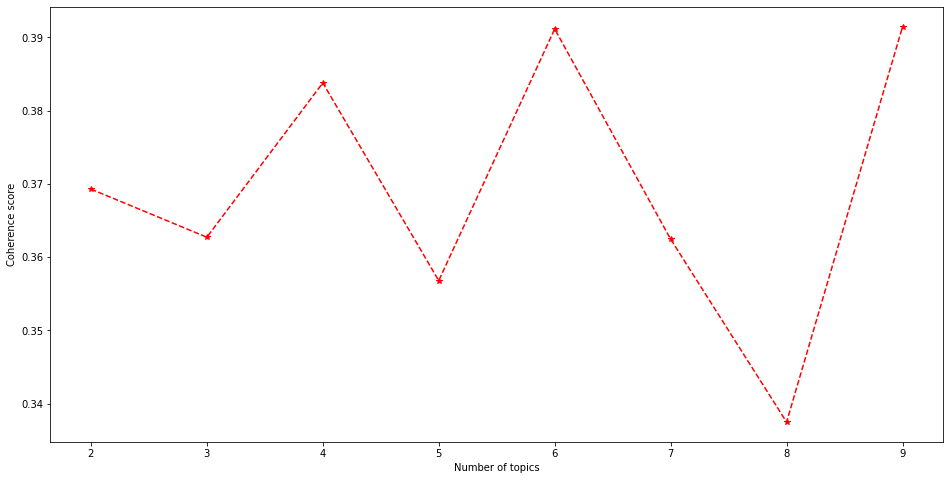

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize = (16,8))
plt.plot(topic_num,cv_score,color='RED', marker='*', linestyle='dashed')
plt.xticks(range(2,10))
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.show()

In [36]:
# Creating LDA model with number of topics as 2
Lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda2(corpus=corpus,id2word=id2word,num_topics=2,random_state=100,update_every=1,chunksize=100,passes=10,alpha="auto")
clear_output()

In [37]:
print(CoherenceModel(model=ldamodel2,texts=df['cleaned_text2'],dictionary=id2word , coherence='c_v').get_coherence())


0.3746652348804843


In [38]:
ldamodel2.print_topics()


[(0,
  '0.016*"kill" + 0.012*"can" + 0.012*"mode" + 0.010*"then" + 0.010*"also" + 0.009*"will" + 0.009*"animal" + 0.007*"creeper" + 0.007*"player" + 0.007*"multiplayer"'),
 (1,
  '0.037*"game" + 0.027*"can" + 0.023*"play" + 0.023*"minecraft" + 0.013*"kid" + 0.012*"good" + 0.011*"build" + 0.011*"fun" + 0.010*"creative" + 0.009*"just"')]

In [39]:
vis2 = gensim_models.prepare(ldamodel2, corpus, id2word, mds="mmds", R=30)
vis2

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=             x         y  topics  cluster       Freq
topic                                               
1     -0.03735  0.117904       1        1  77.432722
0      0.03735 -0.117904       2        1  22.567278, topic_info=       Term        Freq       Total Category  logprob  loglift
4      game  488.000000  488.000000  Default  30.0000  30.0000
131    kill  133.000000  133.000000  Default  29.0000  29.0000
186    then   51.000000   51.000000  Default  28.0000  28.0000
14     play  304.000000  304.000000  Default  27.0000  27.0000
95     mode  145.000000  145.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
192  zombie   17.465893   71.445207   Topic2  -5.4033   0.0800
151   block   16.292276   55.530205   Topic2  -5.4728   0.2624
353      go   14.994356   56.831882   Topic2  -5.5559   0.1562
83   server   15.355202  128.410754   Topic2  -5.5321  -0.6351
222    know   14.980979   83.903162   Topic2  -5.5567  -0.2342

[145 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.995690      age
798       1  0.994612    alpha
53        1  0.559736     also
53        2  0.440643     also
217       1  0.999549  amazing
...     ...       ...      ...
113       1  0.997605    worth
52        1  0.988882    would
52        2  0.013363    would
192       1  0.755824   zombie
192       2  0.237945   zombie

[211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [40]:
# Creating a lookup table for topics
topic_data = pd.DataFrame((ldamodel2.print_topics()),columns=['TopicNumber','TopKeywords'])
topic_data['TopicName'] = ['Suitable for Kidss', 'Not Suitable for Kids'] #enter selected topics names here
topic_data = topic_data[['TopicNumber','TopicName','TopKeywords']]
topic_data['TopKeywords'] = topic_data.TopKeywords.str.replace(r'[^a-z]',' ',regex=True).apply(lambda x: x.split())
topic_data.style.set_properties(subset=['TopKeywords'], **{'width': '300px'}) #space between columns

,TopicNumber,TopicName,TopKeywords
0,0,Suitable for Kidss,"['kill', 'can', 'mode', 'then', 'also', 'will', 'animal', 'creeper', 'player', 'multiplayer']"
1,1,Not Suitable for Kids,"['game', 'can', 'play', 'minecraft', 'kid', 'good', 'build', 'fun', 'creative', 'just']"


In [41]:

df.isnull().sum()


author age         0
recommended age    0
review             0
cleaned_text       0
cleaned_text1      0
cleaned_text2      0
LabelFromVADER     0
dtype: int64

In [42]:
#Creating new columns and inserting topic numbers and names
for y,sent in enumerate(ldamodel2[corpus]):
  topic_num =[]
  topic_details = sorted(sent,key=lambda x: x[1], reverse=True)[:2] # Getting top 2 topics in descending order
  topic_num.append(topic_details[0][0]) # Appending top topic
  if len(topic_details) > 1:
    if topic_details[1][1] > 0.35: # Appending second topic only if it has more than 35% influence on current row
      topic_num.append(topic_details[1][0])
  df.loc[y,'TopicNumber'] = ','.join(str(x) for x in sorted(topic_num))

In [43]:
df.dropna(inplace = True)

In [44]:
for index,topic_num in enumerate(df.TopicNumber):
  topic_name_list=[]
  for single_topic_num in (topic_num).split(','):
    single_topic_num=int(single_topic_num)
    topic_name_list.append(topic_data.loc[topic_data.TopicNumber == single_topic_num,'TopicName'][single_topic_num]) 
  # Extracting topic names from lookup table
  df.loc[index,'TopicName'] =' & '.join(topic_name_list)

In [45]:
df.head()


,author age,recommended age,review,cleaned_text,cleaned_text1,cleaned_text2,LabelFromVADER,TopicNumber,TopicName
0,"Teen, 17 years old",age 7+,Kids dont listent to the parents saying ''ThIs...,kids dont listent to the parents saying this g...,kid listent parent say game sword mean violanc...,"[kid, listent, parent, say, game, sword, mean,...",pos,1,Not Suitable for Kids
1,"Kid, 11 years old",age 2+,I have been playing this game for many years a...,i have been playing this game for many years a...,play game many year never get scared nightmare...,"[play, game, many, year, never, get, scared, n...",pos,1,Not Suitable for Kids
2,"Kid, 12 years old",age 7+,The game is great with no true inappropriate t...,the game is great with no true inappropriate t...,game great true inappropriate thing,"[game, great, true, inappropriate, thing]",pos,1,Not Suitable for Kids
3,"Teen, 13 years old",age 5+,Are you sure you got common sense. I would giv...,are you sure you got common sense i would give...,sure got common sense would give game star dol...,"[sure, got, common_sense, would, give, game, s...",neg,1,Not Suitable for Kids
4,"Kid, 10 years old",age 5+,IDK WHAT TO SAY BUT DIS IS DA BEST GAME EVA,idk what to say but dis is da best game eva,say good game,"[say, good, game]",neg,1,Not Suitable for Kids


In [46]:
df['label'] = df.TopicName.str.cat(df.LabelFromVADER, sep='_')


In [47]:
df.to_csv('Game_Reviews.csv')
